In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movie-dataset/5. Movie Review Dataset/val_movie_review.csv
/kaggle/input/movie-dataset/5. Movie Review Dataset/test_movie_review.csv
/kaggle/input/movie-dataset/5. Movie Review Dataset/5.Description Movie Review Dataset.txt
/kaggle/input/movie-dataset/5. Movie Review Dataset/train_movie_review.csv
/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin.gz
/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin


# Sentiment Classification using RNN, LSTM, and Word2Vec

In this notebook, I perform sentiment analysis on a dataset of movie reviews using three different deep learning models:

- A Simple Recurrent Neural Network (RNN)
- A Long Short-Term Memory network (LSTM)
- An LSTM enhanced with pretrained Word2Vec embeddings

My goal is to compare these models in terms of accuracy and computational efficiency, and assess how word embeddings can improve classification performance. I also include analysis visualizations such as training time comparison, accuracy comparison, and a word frequency chart for exploratory insights.

## Step 1: Importing Libraries
I begin by importing all the necessary libraries including NLTK, Keras, Gensim, and utilities for data handling and visualization.

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 10.9 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time
from collections import Counter
from nltk.tokenize import word_tokenize


nltk.download('stopwords')
nltk.download('punkt')


2025-05-14 08:01:48.647284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747209708.850370      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747209708.907641      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Step 2: Loading and Preprocessing the Data
Here, I define functions to clean the text data by lowercasing, removing noise, and applying lemmatization. This ensures the text is in a format suitable for tokenization and training.

In [5]:
# File paths
train_path = '/kaggle/input/movie-dataset/5. Movie Review Dataset/train_movie_review.csv'
val_path = '/kaggle/input/movie-dataset/5. Movie Review Dataset/val_movie_review.csv'
test_path = '/kaggle/input/movie-dataset/5. Movie Review Dataset/test_movie_review.csv'

In [6]:
# 1. Load datasets
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

In [7]:
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)


Train shape: (35000, 3)
Validation shape: (5000, 3)
Test shape: (10000, 3)


In [8]:
print("Train size:", train_df.size)
print("Validation size:", val_df.size)
print("Test size:", test_df.size)


Train size: 105000
Validation size: 15000
Test size: 30000


In [9]:
train_df.head()


,Unnamed: 0,review,sentiment
0,3774,"Having avoided seeing the movie in the cinema,...",0
1,48396,With this movie I was really hoping that the i...,0
2,1980,Raymond Burr stars as an attorney caught up in...,0
3,6703,A lot people get hung up on this films tag as ...,1
4,28168,I was a fan of Buffy and hoped it would come t...,0


In [10]:
print(" Train class distribution:\n", train_df['sentiment'].value_counts())
print(" Validation class distribution:\n", val_df['sentiment'].value_counts())
print(" Test class distribution:\n", test_df['sentiment'].value_counts())

 Train class distribution:
 sentiment
0    17584
1    17416
Name: count, dtype: int64
 Validation class distribution:
 sentiment
1    2545
0    2455
Name: count, dtype: int64
 Test class distribution:
 sentiment
1    5039
0    4961
Name: count, dtype: int64


### Pre-processing

In [11]:
# Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def preprocess_text(text):
    text = text.lower()
    text = contractions.fix(text)
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+|#|[^a-zA-Z\s]", "", text)
    text = re.sub(r"\d+", "", text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)


In [12]:

def load_and_clean(path):
    df = pd.read_csv(path)
    df.dropna(subset=['review', 'sentiment'], inplace=True)
    df = df[df['sentiment'].isin([0, 1])]
    df['review'] = df['review'].astype(str)
    df['sentiment'] = df['sentiment'].astype(int)
    df['cleaned_text'] = df['review'].apply(preprocess_text)
    return df


In [13]:
train_df = load_and_clean(train_path)
val_df = load_and_clean(val_path)
test_df = load_and_clean(test_path)

## Step 3: Word Frequency Visualization
To understand common patterns in the dataset, I generate a bar chart showing the most frequent words in the reviews.

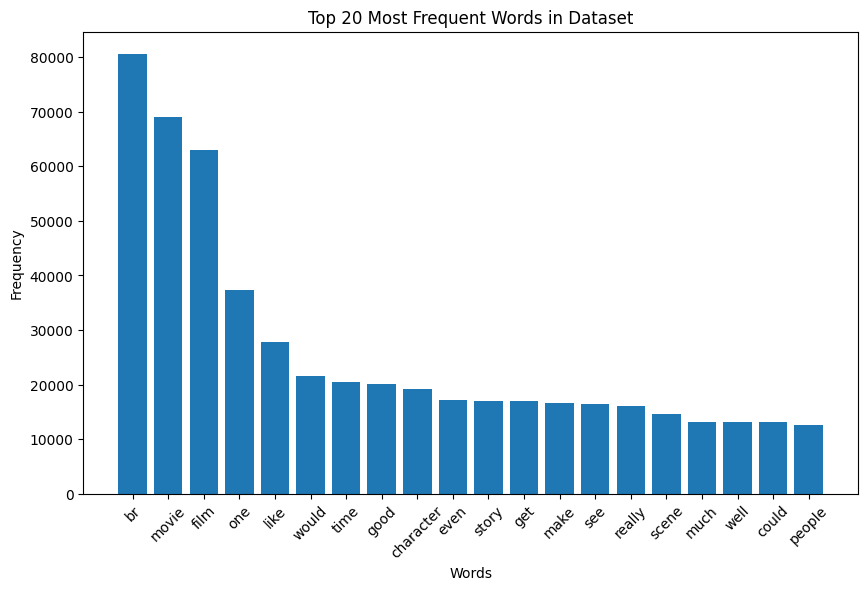

In [14]:
from collections import Counter
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

# Combine all cleaned text into one string
all_words = " ".join(train_df['cleaned_text'].tolist())
tokens = word_tokenize(all_words)

# Frequency Analysis
word_freq = Counter(tokens)
common_words = word_freq.most_common(20)

# Bar Chart: Top 20 Most Frequent Words
words, freqs = zip(*common_words)
plt.figure(figsize=(10, 6))
plt.bar(words, freqs)
plt.title("Top 20 Most Frequent Words in Dataset")
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()


For top words i display using word cloud

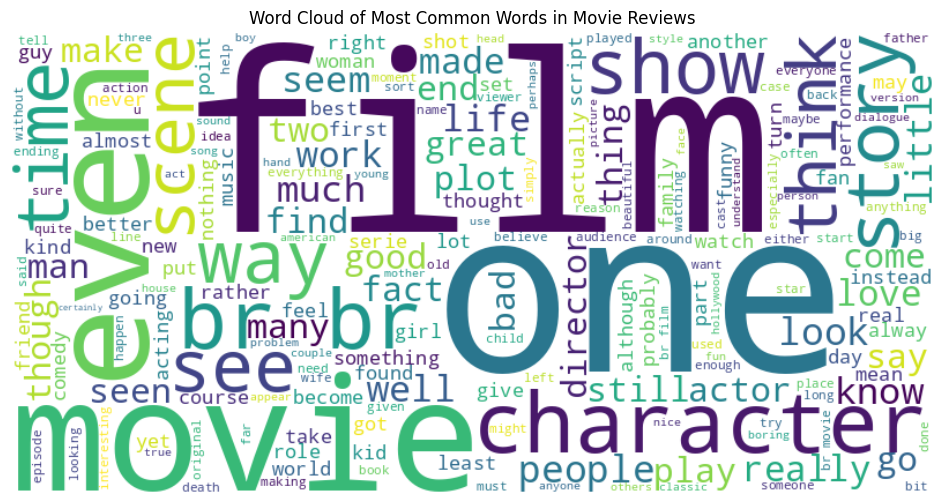

In [15]:
# Word Cloud Visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Common Words in Movie Reviews")
plt.show()


## Step 4: Tokenization and Padding
I convert the cleaned text data into sequences of integers and apply padding to make all sequences the same length. This is essential for feeding into the neural network models.

In [16]:
X_train = train_df['cleaned_text'].values
y_train = train_df['sentiment'].values
X_val = val_df['cleaned_text'].values
y_val = val_df['sentiment'].values
X_test = test_df['cleaned_text'].values
y_test = test_df['sentiment'].values


In [17]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

In [18]:
import pickle
# Save tokenizer
with open("tokenizer.pkl", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [20]:
seq_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(seq_lengths, 95))

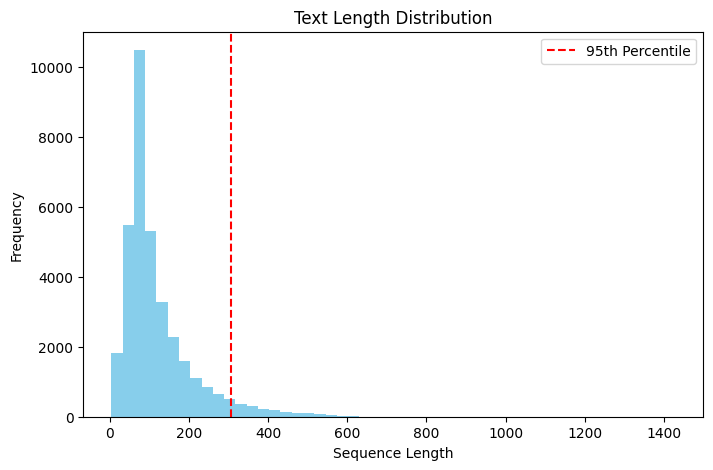

In [21]:
X_seq = tokenizer.texts_to_sequences(train_df['cleaned_text'])
seq_lengths = [len(seq) for seq in X_train_seq]
plt.figure(figsize=(8, 5))
plt.hist(seq_lengths, bins=50, color='skyblue')
plt.title('Text Length Distribution')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axvline(np.percentile(seq_lengths, 95), color='red', linestyle='dashed', label='95th Percentile'
)
plt.legend()
plt.show()

In [22]:
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


## Step 5: Defining the Models
I define three types of models:
- A simple RNN
- An LSTM
- An LSTM with pretrained Word2Vec embeddings loaded from the Google News corpus

In [23]:
def build_rnn_model():
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128, input_length=max_len),
        SimpleRNN(64),
        Dense(1, activation='sigmoid')
    ])
    return model


In [24]:
def build_lstm_model():
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128, input_length=max_len),
        LSTM(64),
        Dense(1, activation='sigmoid')
    ])
    return model


In [25]:
from gensim.models import KeyedVectors
import kagglehub

def build_lstm_w2v_model(tokenizer):
    path = kagglehub.dataset_download("leadbest/googlenewsvectorsnegative300")
    word2vec_model = KeyedVectors.load_word2vec_format(f'{path}/GoogleNews-vectors-negative300.bin', binary=True)
    vocab_size = len(tokenizer.word_index) + 1
    embedding_dim = 300
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, index in tokenizer.word_index.items():
        if word in word2vec_model:
            embedding_matrix[index] = word2vec_model[word]
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
        LSTM(64),
        Dense(1, activation='sigmoid')
    ])
    return model


## Step 6: Training and Evaluation Functions
I create functions to compile, train, and evaluate each model. I also measure the training time using a helper function to compare model efficiency.

In [26]:
def compile_model(model):
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])


In [27]:

def train_model(model, name, X_train, y_train, X_val, y_val):
    checkpoint = ModelCheckpoint(f"{name}_best.keras", monitor='val_accuracy', save_best_only=True, mode='max', verbose=0)
    early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=0)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64, callbacks=[checkpoint, early_stop])
    return history


In [28]:

def timed_training(model, name, X_train, y_train, X_val, y_val):
    start = time.time()
    history = train_model(model, name, X_train, y_train, X_val, y_val)
    end = time.time()
    print(f"{name} training time: {end - start:.2f} seconds")
    return history, end - start


In [29]:

def plot_history(history, name):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [30]:

def evaluate_model(model, name, X_test, y_test):
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    print(f"{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


## Step 7: Model Training and Evaluation
Each model is trained, and I evaluate its performance using accuracy and a confusion matrix. I also visualize the training and validation metrics.

Epoch 1/50


I0000 00:00:1747209848.340549      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747209848.341301      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1747209850.881983     110 service.cc:148] XLA service 0x7934280058e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747209850.882483     110 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747209850.882504     110 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747209851.272510     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/547 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.5130 - loss: 0.6938

I0000 00:00:1747209852.423252     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


547/547 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5035 - loss: 0.6938 - val_accuracy: 0.4984 - val_loss: 0.6927
Epoch 2/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.5322 - loss: 0.6879 - val_accuracy: 0.5118 - val_loss: 0.6926
Epoch 3/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.5472 - loss: 0.6794 - val_accuracy: 0.5002 - val_loss: 0.6942
Epoch 4/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.5763 - loss: 0.6640 - val_accuracy: 0.5450 - val_loss: 0.6881
Epoch 5/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.6747 - loss: 0.6139 - val_accuracy: 0.5760 - val_loss: 0.6924
Epoch 6/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.7536 - loss: 0.5303 - val_accuracy: 0.5836 - val_loss: 0.7106
Epoch 7/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.8242 - loss: 0.4303 - val_accuracy: 0.5942 - val_loss: 0.7562
Epoch 8/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.8798 - loss: 0.3325 - val_accurac

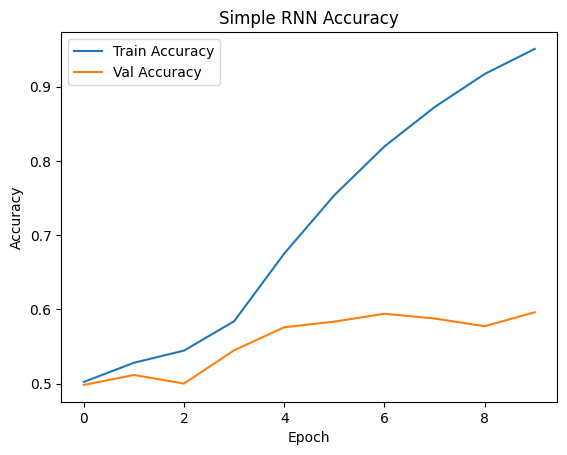

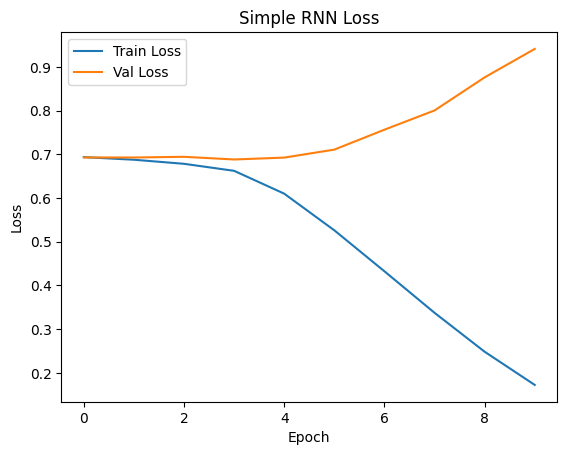

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Simple RNN Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.52      0.53      4961
           1       0.55      0.57      0.56      5039

    accuracy                           0.55     10000
   macro avg       0.55      0.55      0.55     10000
weighted avg       0.55      0.55      0.55     10000



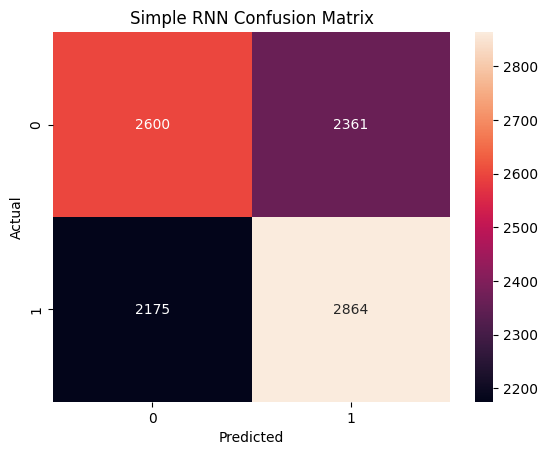

In [31]:
rnn_model = build_rnn_model()
compile_model(rnn_model)
history_rnn, time_rnn = timed_training(rnn_model, "rnn_model", X_train_pad, y_train, X_val_pad, y_val)
plot_history(history_rnn, "Simple RNN")
evaluate_model(rnn_model, "Simple RNN", X_test_pad, y_test)

Epoch 1/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4977 - loss: 0.6932 - val_accuracy: 0.4944 - val_loss: 0.6945
Epoch 2/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5092 - loss: 0.6927 - val_accuracy: 0.4942 - val_loss: 0.6948
Epoch 3/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5096 - loss: 0.6915 - val_accuracy: 0.4996 - val_loss: 0.6925
Epoch 4/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5191 - loss: 0.6877 - val_accuracy: 0.5006 - val_loss: 0.6948
Epoch 5/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5310 - loss: 0.6853 - val_accuracy: 0.5048 - val_loss: 0.6915
Epoch 6/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5275 - loss: 0.6860 - val_accuracy: 0.5148 - val_loss: 0.6909
Epoch 7/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5246 - loss: 0.6830 - val_accuracy: 0.5120 - val_loss: 0.6868
Epoch 8/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5444 - loss: 0.6919 - val_acc

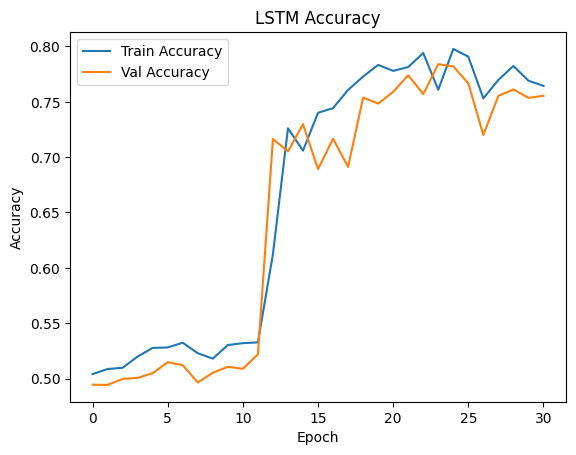

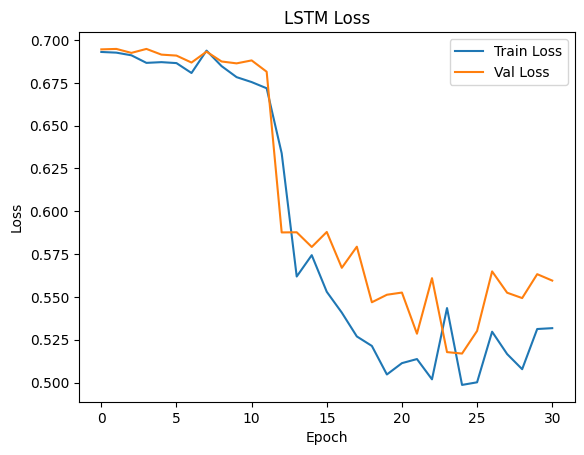

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79      4961
           1       0.83      0.71      0.76      5039

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000



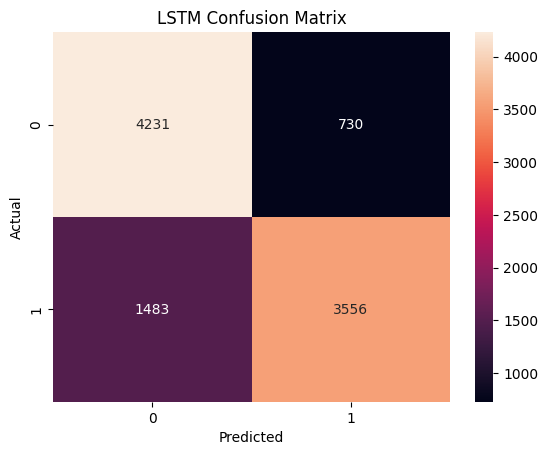

In [32]:
lstm_model = build_lstm_model()
compile_model(lstm_model)
history_lstm, time_lstm = timed_training(lstm_model, "lstm_model", X_train_pad, y_train, X_val_pad, y_val)
plot_history(history_lstm, "LSTM")
evaluate_model(lstm_model, "LSTM", X_test_pad, y_test)

Epoch 1/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5070 - loss: 0.6929 - val_accuracy: 0.4982 - val_loss: 0.6925
Epoch 2/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.5845 - loss: 0.6667 - val_accuracy: 0.7560 - val_loss: 0.5883
Epoch 3/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.7680 - loss: 0.5509 - val_accuracy: 0.7762 - val_loss: 0.5197
Epoch 4/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7604 - loss: 0.5534 - val_accuracy: 0.7644 - val_loss: 0.5307
Epoch 5/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7341 - loss: 0.5690 - val_accuracy: 0.7182 - val_loss: 0.5686
Epoch 6/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7586 - loss: 0.5374 - val_accuracy: 0.7466 - val_loss: 0.6086
Epoch 7/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7650 - loss: 0.5526 - val_accuracy: 0.5458 - val_loss: 0.8453
Epoch 8/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5662 - loss: 0.7180 - val_acc

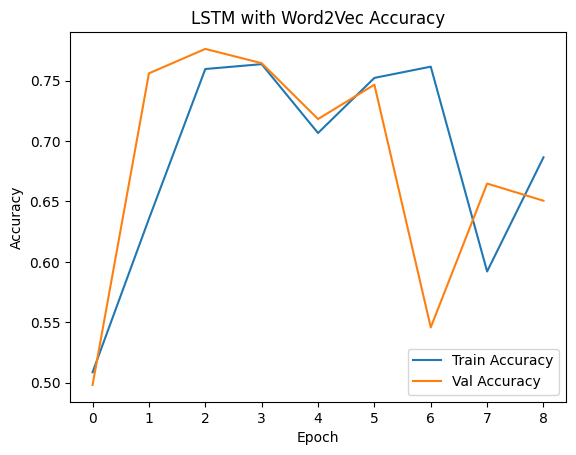

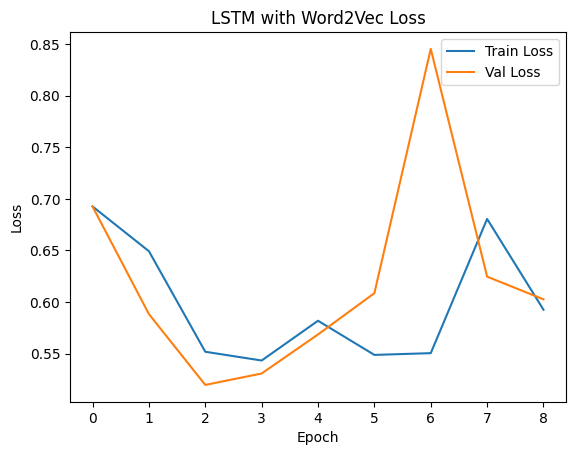

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
LSTM with Word2Vec Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.65      0.73      4961
           1       0.72      0.88      0.79      5039

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.76     10000
weighted avg       0.78      0.77      0.76     10000



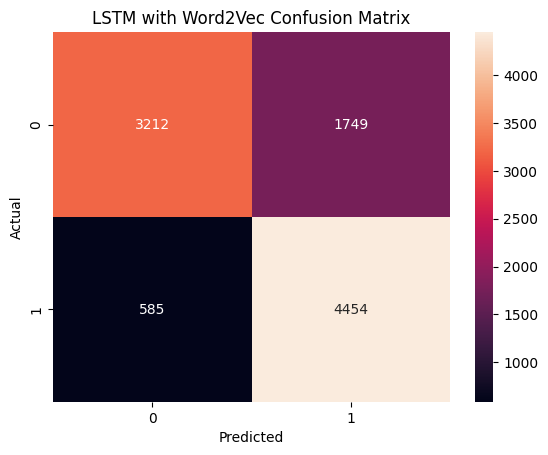

In [33]:
lstm_w2v_model = build_lstm_w2v_model(tokenizer)
compile_model(lstm_w2v_model)
history_lstm_w2v, time_lstm_w2v = timed_training(lstm_w2v_model, "lstm_w2v_model", X_train_pad, y_train, X_val_pad, y_val)
plot_history(history_lstm_w2v, "LSTM with Word2Vec")
evaluate_model(lstm_w2v_model, "LSTM with Word2Vec", X_test_pad, y_test)

## Step 8: Comparative Analysis
I present bar charts comparing the training time and validation accuracy of all three models. This helps visualize the trade-offs between model complexity and performance.

In [34]:
models = ['Simple RNN', 'LSTM', 'LSTM + Word2Vec']
times = [time_rnn, time_lstm, time_lstm_w2v]
accs = [history_rnn.history['val_accuracy'][-1], history_lstm.history['val_accuracy'][-1], history_lstm_w2v.history['val_accuracy'][-1]]

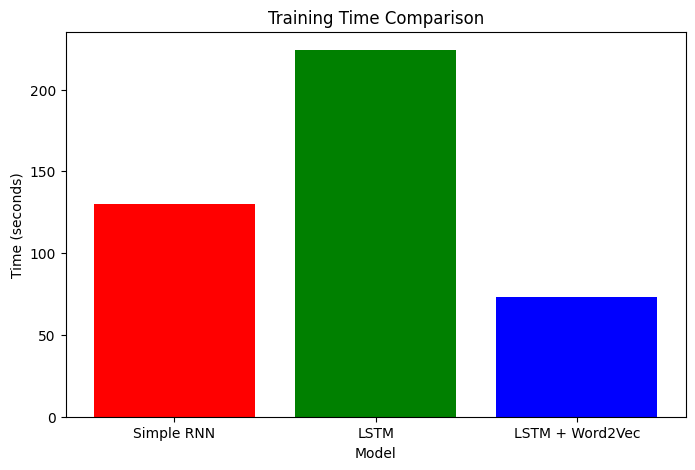

In [35]:
plt.figure(figsize=(8, 5))
plt.bar(models, times, color=['red', 'green', 'blue'])
plt.title('Training Time Comparison')
plt.xlabel('Model')
plt.ylabel('Time (seconds)')
plt.show()

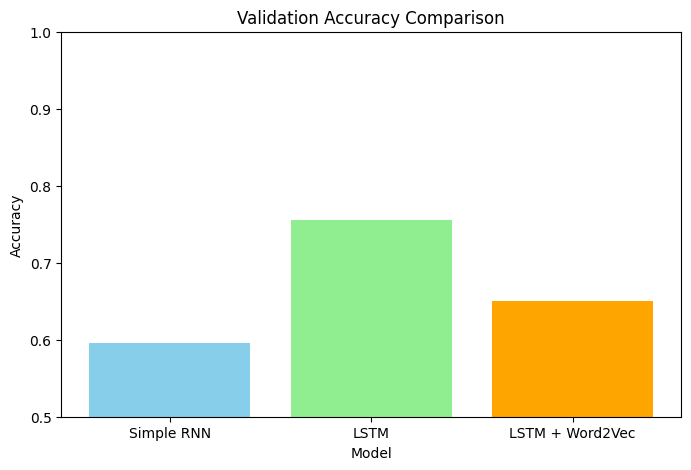

In [36]:
plt.figure(figsize=(8, 5))
plt.bar(models, accs, color=['skyblue', 'lightgreen', 'orange'])
plt.title('Validation Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1)
plt.show()